<a href="https://colab.research.google.com/github/jeremysayz/covid19_running_analysis/blob/master/COVID19_State_Trajectories.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Use "Copy to Drive" option (or other File menu options) to make this an interactive web page - then use Shift-Enter on each "cell" (block like this with a number to the left) to execute the code. (see Help menu above if you need help learning about Colab Notebooks)

Also tracked in GitHub (https://github.com/jeremysayz/covid19_running_analysis)


# Prepare libraries and functions needed

In [1]:
import urllib
import datetime

import scipy.signal as spsig
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt


In [2]:
plt.style.use({
        "axes.labelsize":20,
        "font.size":18,
        "lines.markersize":8,
        "xtick.labelsize":18,
        "ytick.labelsize":18,
        "legend.fontsize":12,
        "axes.titlesize":18,
        "figure.figsize":[12, 8],
    })


In [9]:
def testcount_corrected(statelist, fromdate="2020-04-01"):
    """Give plots for listed state(s) for total number of positives (by day) and PERCENT of positives (by day) 
    Shows how testing volume is influencing results (or not). Based on data from covidtracking.com
    
    Inputs:
        statelist  : list-like object giving states for which plots should be made. An empty string in this list
                     is interpreted as the entire US (gives whole US summaries)
    Optional Inputs:
        fromdate   : YYYY-MM-DD formatted string saying the first date of results to show (note, March values
                     are fairly chaotic as testing was ramping up and being more targeted. April 1st is the
                     date things seemed to settle down)
    """
    for state in statelist:

        if state!="":
            state_url = "state/"+state.lower().replace(" ","-")
        else:
            state_url = "us-daily"

        try:
            with urllib.request.urlopen(f'https://covidtracking.com/data/{state_url}') as response:
               html = response.read()
        except urllib.error.HTTPError:
            continue #skip this "state" if it can't be read

        parsed = pd.read_html(html)

        if state!="":
            data = parsed[1].copy()
        else:
            #Looking at WHOLE US
            data = parsed[0].copy()
            data['Cases'] = data['Positive']
            state = 'United States'

        fmt = '%a %b %d %Y'

        data['Date'] = data['Date'].apply(lambda v: datetime.datetime.strptime(v, fmt))
        data = data.sort_values('Date')

        data['New Cases'] = data['Cases'].diff()
        data['New Cases (%)'] = data['New Cases']/data['New Tests']*100

        #NOTE: make days with >50% new positive cases MISSING - these are likely bolus data dumps from things like prisons.
        # This means our running average will be UNDER estimating positive cases for the windows where these days fall. 
        # This missing value will cause the entire ROW to be dropped (so for both raw counts and %)
        data.loc[data['New Cases (%)']>50, 'New Cases (%)'] = np.nan

        data = data.set_index('Date')

        for ax,pltinfo in enumerate([
            ('New Cases (%)', plt.cm.tab10(0), '% Positve (Blue)'),
            ('New Cases', plt.cm.tab10(1), 'Total Count (Orange)'),
        ]):
            col,color,lbl = pltinfo
            if ax==1:
                plt.gca().twinx()  #second axes on right
            else:
                plt.grid(True, color=color)  #give grid for ONLY first set of data

            coldf = data.loc[datetime.datetime.strptime(fromdate,'%Y-%m-%d'):, col].dropna()

            #main data
            plt.plot(coldf.index.values, coldf.values,'-', color=color)

            #Running average (actually a 1st order savgol with 7-point window)
            # NOTE: dropped days will be ignored in this smooth, so it's not really 7-days but 7 DATA POINTS
            coldf_sm = spsig.savgol_filter(coldf.values, 7, 1, 0)
            plt.plot(coldf.index.values, coldf_sm,'-', linewidth=6, color=color)

            plt.ylabel(lbl)
            plt.xticks(rotation=90)

        plt.title("{} (as of {})".format(state.capitalize(), datetime.datetime.now().strftime("%Y-%m-%d")))
        plt.xlabel(data.index.name)
        plt.show()

# Run the function above for the state(s) of interest

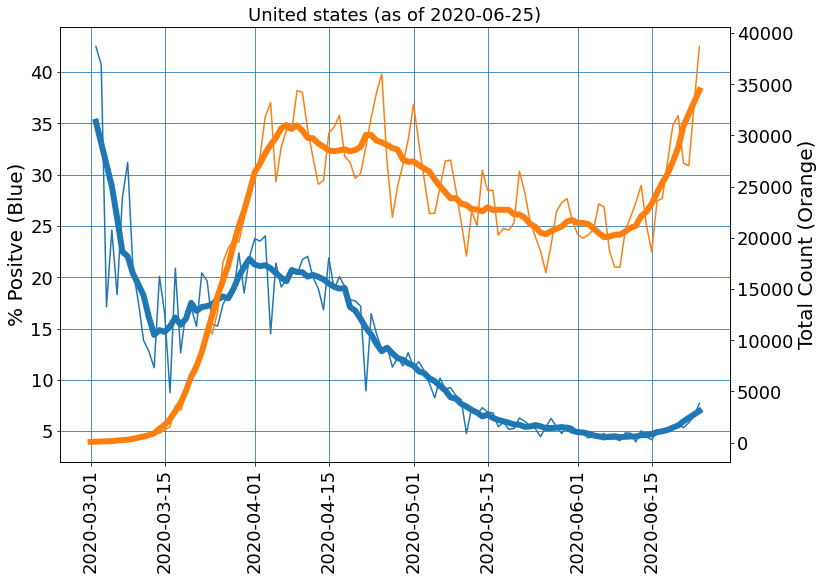

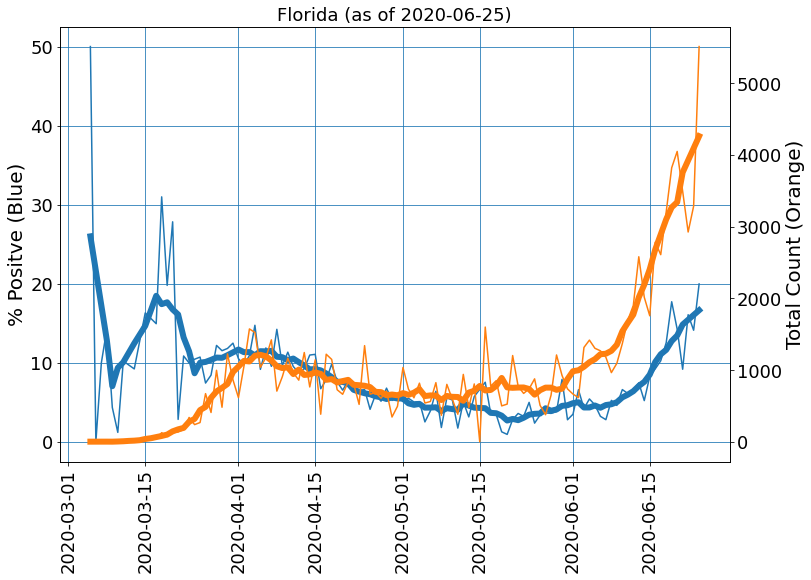

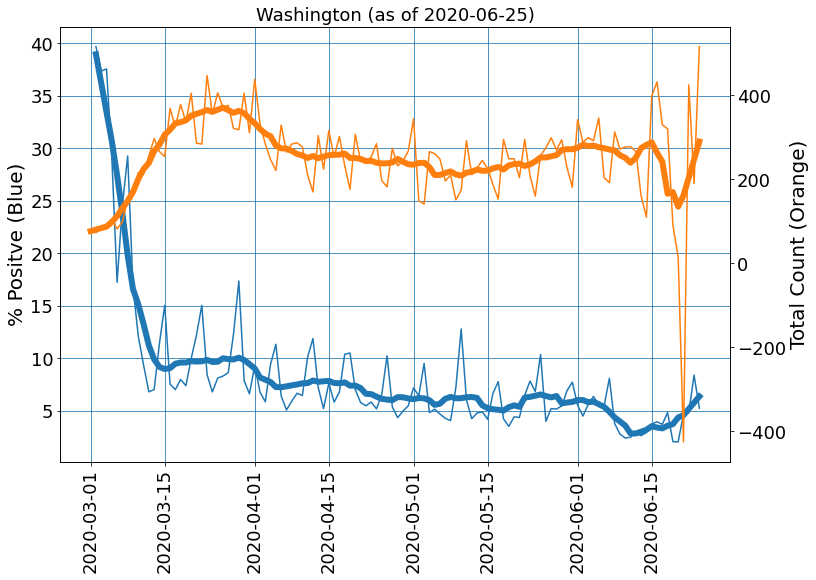

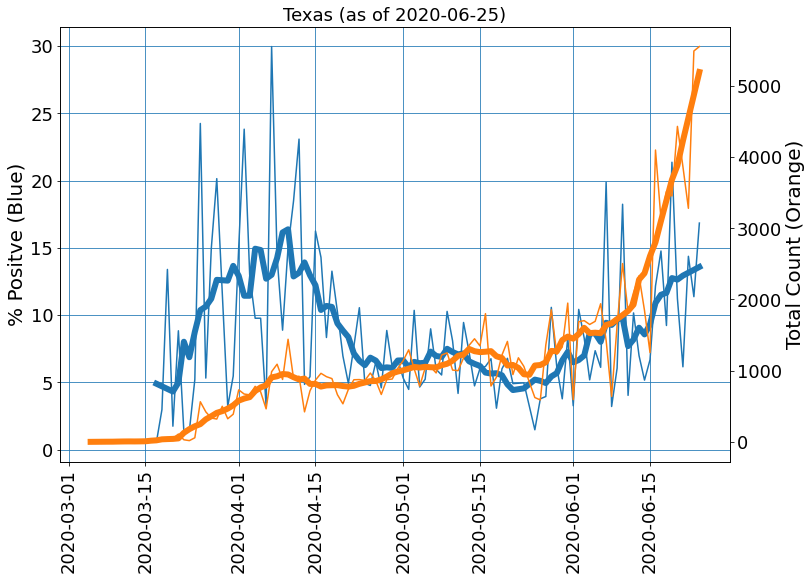

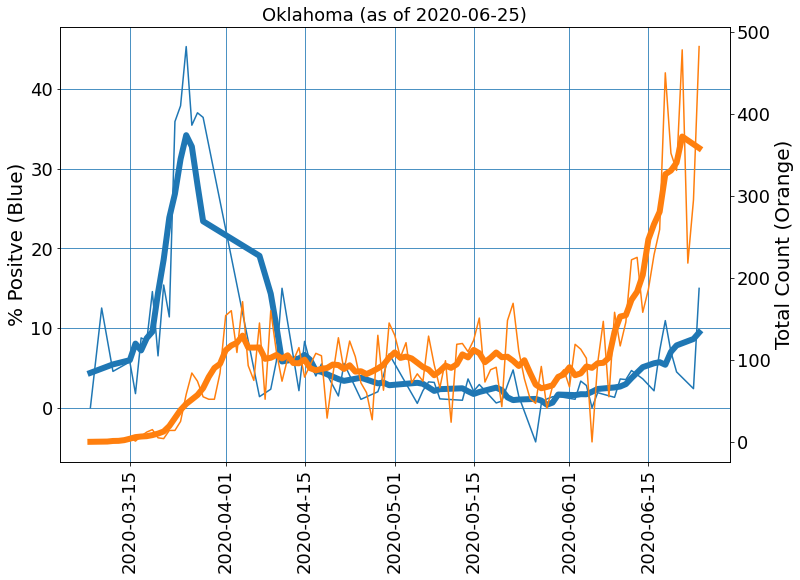

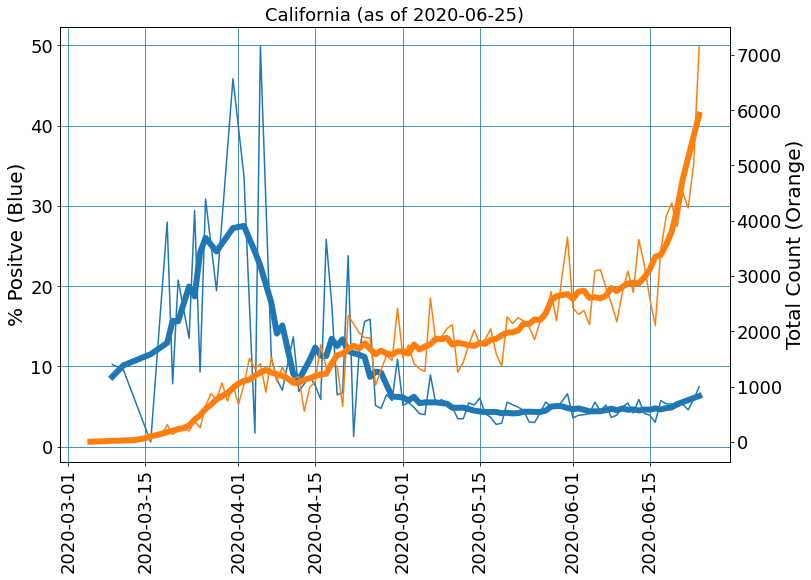

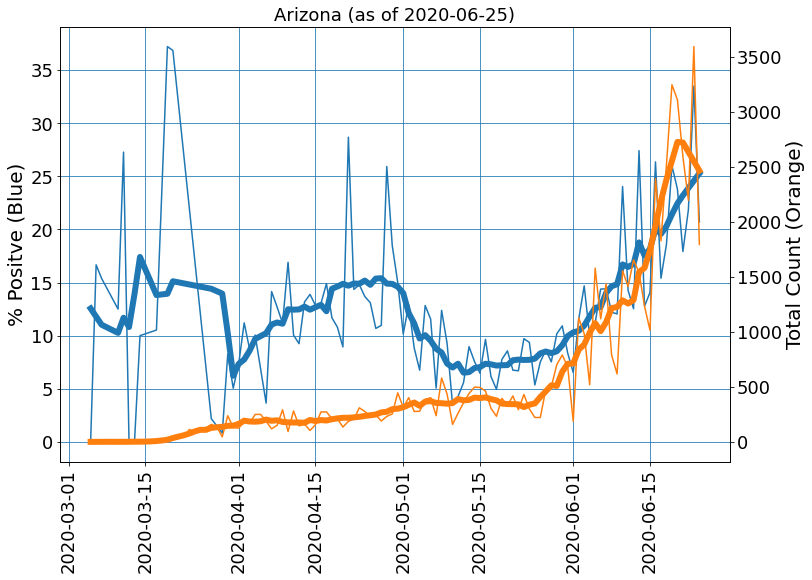

In [11]:
testcount_corrected(['', 'florida', 'washington', 'texas', 'oklahoma', 'california', 'arizona'])